In [13]:
%pip install matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd

df = pd.read_csv('output/k6-lint-results.csv')
# limpar nomes das colunas
df.columns = df.columns.str.lower().str.strip()


# limpar valores string em todas as colunas do tipo object
df = df.apply(lambda col: col.str.lower().str.strip() if col.dtype == "object" else col)

# mostrar formato final
df.shape

(500, 13)

In [15]:
# Remove arquivos que não conseguiu clonar
df = df[df['file_exists'] == 'yes']

# Remove as colunas que não importam
df.drop(columns=['url','file_exists','clone_error'], inplace=True)
df.shape

(500, 10)

In [16]:
# df = df[(df['k6-performance/no-heavy-init-context'] != 0) | (df['k6-performance/require-check'] != 0) | (df['k6-performance/require-tags'] != 0) | (df['k6-performance/require-thresholds'] != 0)]

#Adiciona uma coluna com o total de smells em cada repositorio
violation_cols = [c for c in df.columns if c.startswith('k6-performance/') and not c.endswith('_loc')]
df['total_violations'] = df[violation_cols].sum(axis=1)

#remove repositorios sem smell
# df = df[df['total_violations'] > 0]

df.shape

(500, 11)

In [17]:
# agregações básicas: soma de violações por repositório
violations_by_repo = df.groupby('repositório')['total_violations'].sum().sort_values(ascending=False).head(20)
violations_by_repo

repositório
vifor/faas-to-iaas-migration-framework                           28
boavizta/ecobenchmark-applicationweb-backend                     22
mateusoliveiraps/k6_estudos                                      17
pagopa/pn-load-test                                              17
firmansyah-github/quarkus-generated-test                         15
jwcastillo/0_to_100_k6                                           13
rxtcp/dissertation-on-measuring-system-performance-indicators    11
kotoant/spring-petclinic-rest                                    11
tomkaith13/session-based-dataprocessing                          10
bcwilsondotcom/nx-monorepo-template                              10
hyperspace-metaverse/xk6-socketio                                10
weaviate/xk6-weaviate                                             9
saifautomatron/k6                                                 9
jamesgrant1811/k6-udemy                                           9
mattpchoy/microservicearchitecture  

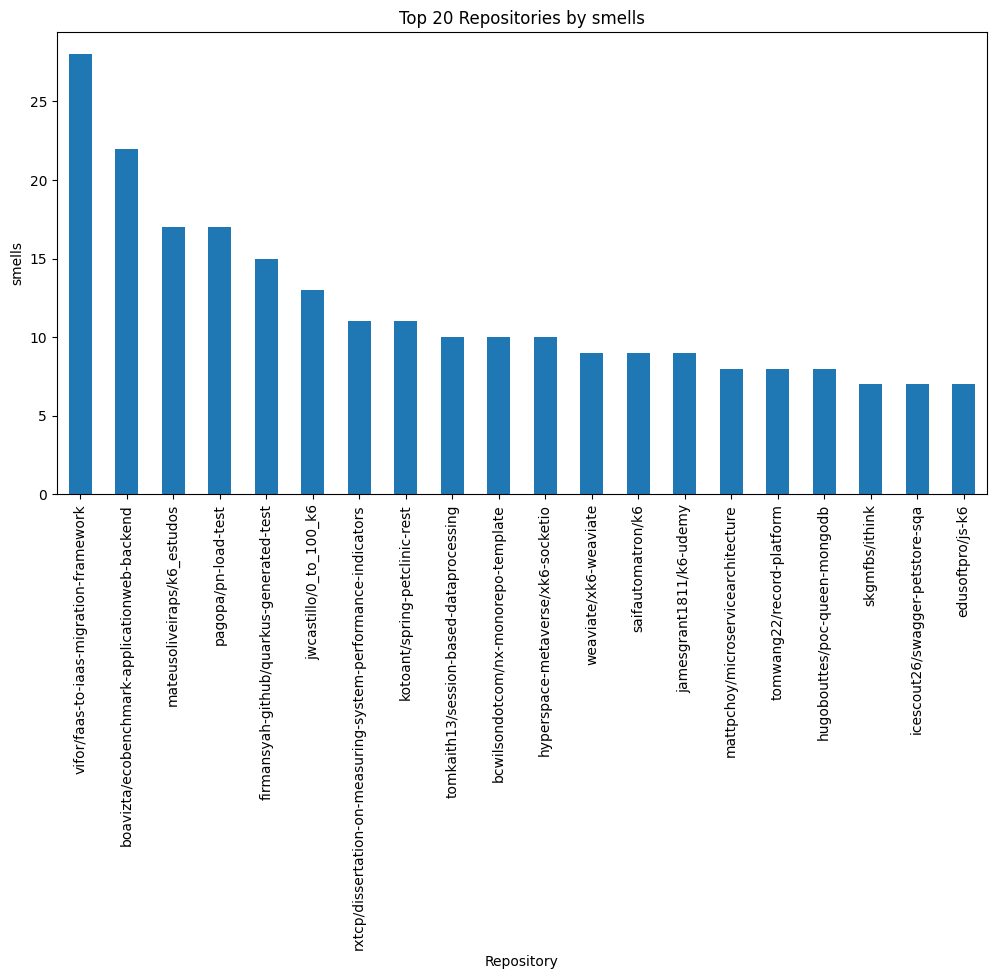

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
violations_by_repo.plot(kind='bar')
plt.title('Top 20 Repositories by smells')
plt.xlabel('Repository')
plt.ylabel('smells')
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()

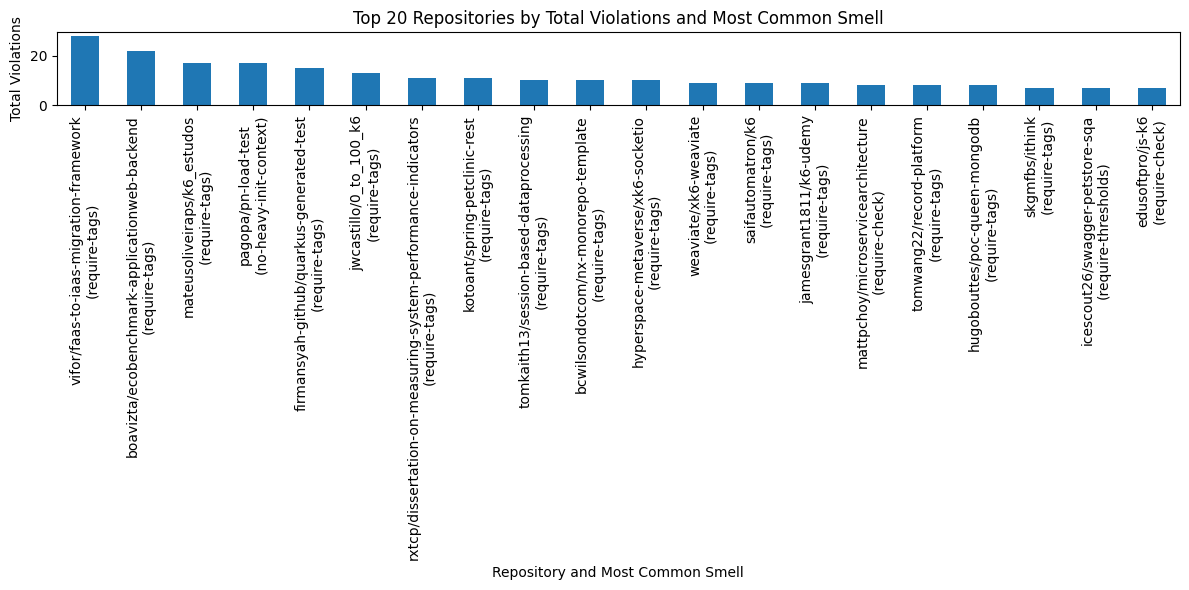

In [19]:
def get_most_common_smell(row):
    smell_counts = row[violation_cols].sort_values(ascending=False)
    for smell, count in smell_counts.items():
        if count > 0:
            return smell.replace('k6-performance/', '')
    return 'No violations'

violations_by_repo_with_smell = df.groupby('repositório').apply(lambda x: pd.Series({
    'total_violations': x['total_violations'].sum(),
    'most_common_smell': get_most_common_smell(x.iloc[0]) # Assuming the most common smell is consistent across files in the same repo for simplicity
}), include_groups=False).sort_values(by='total_violations', ascending=False).head(20)

plt.figure(figsize=(12, 6))
violations_by_repo_with_smell['total_violations'].plot(kind='bar')
plt.title('Top 20 Repositories by Total Violations and Most Common Smell')
plt.xlabel('Repository and Most Common Smell')
plt.ylabel('Total Violations')
plt.xticks(rotation=90)

# Update x-axis labels to include the most common smell
plt.gca().set_xticklabels([f"{repo}\n({smell})" for repo, smell in zip(violations_by_repo_with_smell.index, violations_by_repo_with_smell['most_common_smell'])])

plt.tight_layout()
plt.show()

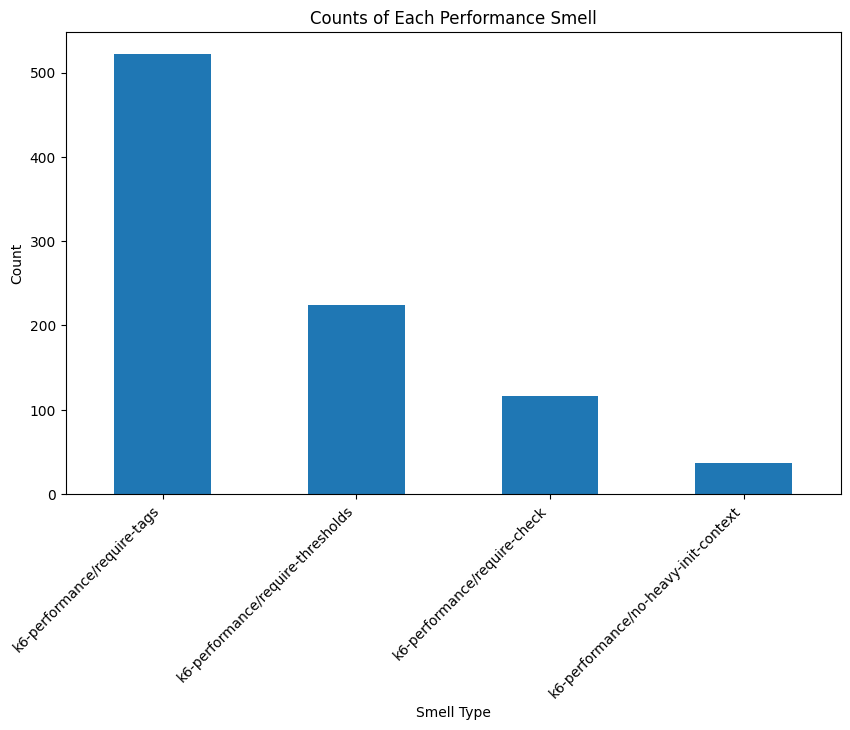

In [ ]:
smell_counts = df[violation_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
smell_counts.plot(kind='bar')
plt.title('Counts of Each Smell')
plt.xlabel('Smell Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()

In [21]:
# Combine the two series into a DataFrame for plotting
# smell_comparison_df = pd.DataFrame({
#     'total_occurrences': smell_counts,
#     'num_repositories': smell_repo_counts_series
# })

# plt.figure(figsize=(10, 8))
# plt.scatter(smell_comparison_df['total_occurrences'], smell_comparison_df['num_repositories'])

# # Add labels for each point
# for i, smell in enumerate(smell_comparison_df.index):
#     plt.annotate(smell.replace('k6-performance/', ''), (smell_comparison_df['total_occurrences'].iloc[i], smell_comparison_df['num_repositories'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')

# plt.title('Smell Occurrences vs. Number of Repositories')
# plt.xlabel('Total Occurrences')
# plt.ylabel('Number of Repositories')
# plt.grid(True)
# plt.show()

In [22]:
# Combine the two series into a DataFrame for plotting
# smell_comparison_df = pd.DataFrame({
#     'total_occurrences': smell_counts,
#     'num_repositories': smell_repo_counts_series
# })

# plt.figure(figsize=(10, 8))
# plt.scatter(smell_comparison_df['total_occurrences'], smell_comparison_df['num_repositories'])

# # Add labels for each point
# for i, smell in enumerate(smell_comparison_df.index):
#     plt.annotate(smell.replace('k6-performance/', ''), (smell_comparison_df['total_occurrences'].iloc[i], smell_comparison_df['num_repositories'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')

# plt.title('Smell Occurrences vs. Number of Repositories')
# plt.xlabel('Total Occurrences')
# plt.ylabel('Number of Repositories')
# plt.grid(True)
# plt.show()

In [23]:
# Count the number of repositories with each type of smell
smell_repo_counts = {}
for smell_col in violation_cols:
    # Count unique repositories where the smell count is greater than 0
    smell_repo_counts[smell_col] = df[df[smell_col] > 0]['repositório'].nunique()

smell_repo_counts_series = pd.Series(smell_repo_counts).sort_values(ascending=False)

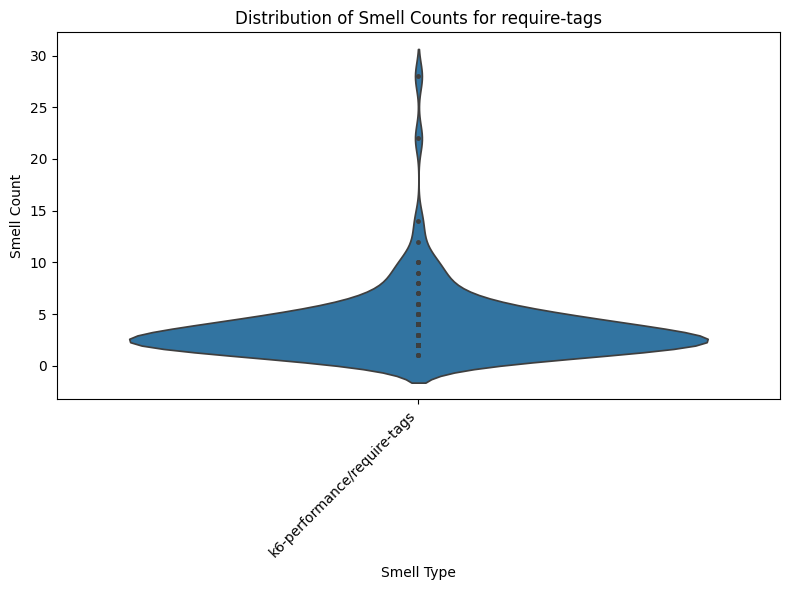

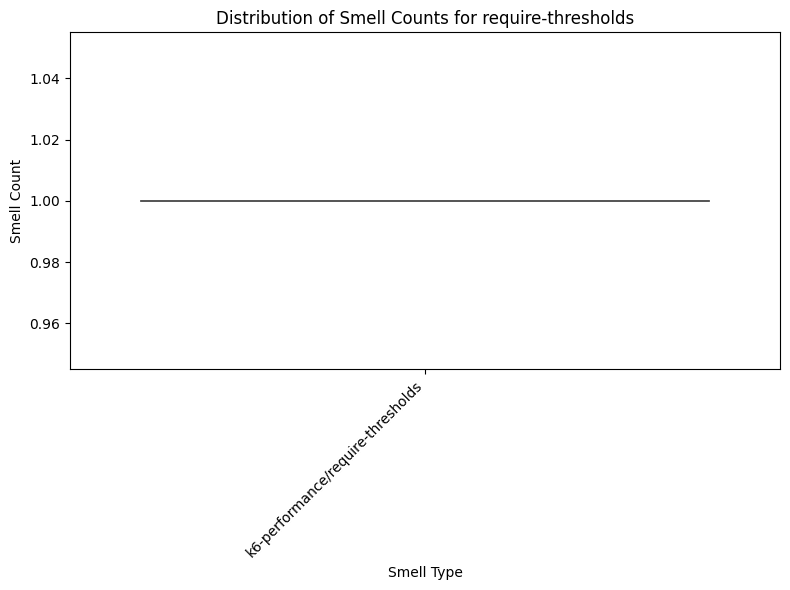

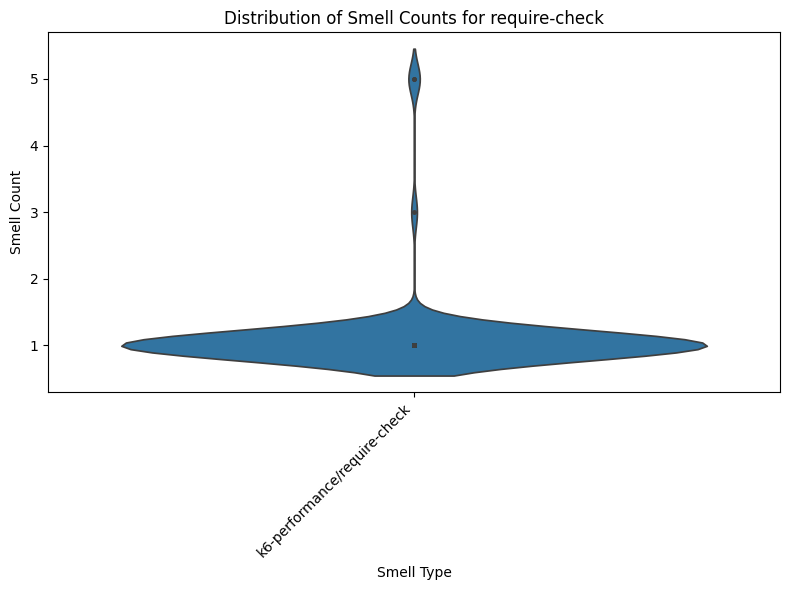

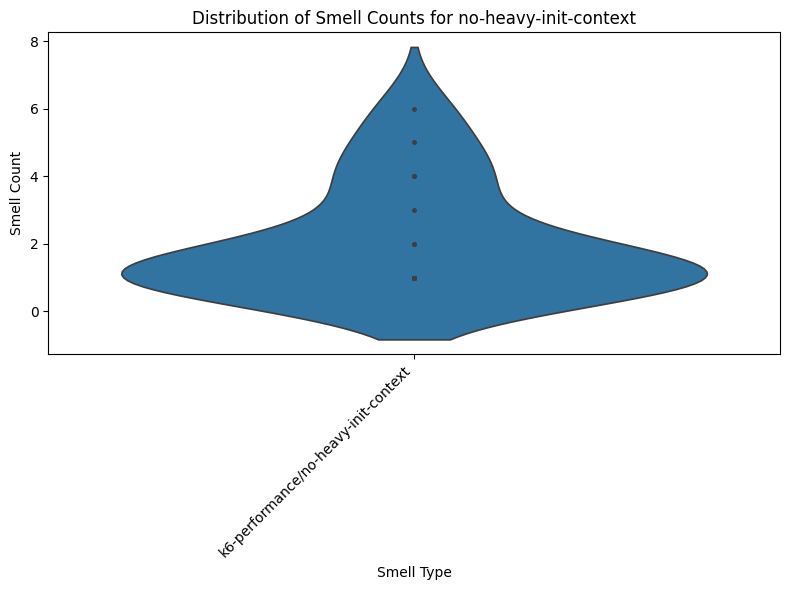

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame to long format for plotting
df_melted = df.melt(value_vars=violation_cols, var_name='Smell Type', value_name='Violation Count')

# Remove rows with zero violations for a clearer plot
df_melted = df_melted[df_melted['Violation Count'] > 0]

# Get the top 4 smells based on total occurrences
top_4_smells = smell_counts.head(4).index.tolist()

for smell_type in top_4_smells:
    df_smell = df_melted[df_melted['Smell Type'] == smell_type]

    if not df_smell.empty:
        plt.figure(figsize=(8, 6))
        sns.violinplot(x='Smell Type', y='Violation Count', data=df_smell, inner='points')
        plt.title(f'Distribution of Smell Counts for {smell_type.replace("k6-performance/", "")}')
        plt.xlabel('Smell Type')
        plt.ylabel('Smell Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No violations found for {smell_type.replace('k6-performance/', '')}")

In [25]:
# Filter the original DataFrame to include only the top repositories with the most violations
top_repos = violations_by_repo.index
df_top_repos = df[df['repositório'].isin(top_repos)]

# Display the filtered DataFrame
display(df_top_repos)

,repositório,arquivo,k6-performance/no-heavy-init-context,k6-performance/no-heavy-init-context_loc,k6-performance/require-check,k6-performance/require-check_loc,k6-performance/require-tags,k6-performance/require-tags_loc,k6-performance/require-thresholds,k6-performance/require-thresholds_loc,total_violations
28,mattpchoy/microservicearchitecture,src/soak.js,0,NaN,1,12:1,0,NaN,1,4:14,2
29,mattpchoy/microservicearchitecture,src/constantload.js,0,NaN,5,75:17; 80:17; 85:17; 102:17; 107:17,0,NaN,1,22:14,6
40,kotoant/spring-petclinic-rest,script.js,0,NaN,0,NaN,10,146:26; 159:24; 168:26; 172:25; 175:23; 178:25...,1,5:14,11
69,jamesgrant1811/k6-udemy,groups.js,0,NaN,0,NaN,4,15:19; 19:13; 20:13; 26:9,0,NaN,4
70,jamesgrant1811/k6-udemy,custom-metrics-example.js,0,NaN,1,18:1,2,19:15; 23:11,0,NaN,3
71,jamesgrant1811/k6-udemy,random-sleep.js,0,NaN,1,10:1,0,NaN,1,5:14,2
109,mateusoliveiraps/k6_estudos,k6-load.js,0,NaN,0,NaN,8,44:21; 62:23; 86:24; 103:25; 130:23; 149:27; 1...,1,15:14,9
110,mateusoliveiraps/k6_estudos,k6-smoke.js,0,NaN,0,NaN,8,45:21; 63:23; 87:24; 104:25; 131:23; 150:27; 1...,0,NaN,8
118,rxtcp/dissertation-on-measuring-system-perform...,script.js,0,NaN,0,NaN,10,146:26; 159:24; 168:26; 172:25; 175:23; 178:25...,1,5:14,11
125,saifautomatron/k6,fundamentals/groups_tags.js,0,NaN,0,NaN,4,15:19; 19:13; 20:13; 26:9,0,NaN,4


In [26]:
# Function to identify outliers using IQR
def identify_outliers(df, smell_col):
    Q1 = df[smell_col].quantile(0.25)
    Q3 = df[smell_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[smell_col] < lower_bound) | (df[smell_col] > upper_bound)]
    return outliers[['repositório', 'arquivo', smell_col]].rename(columns={smell_col: 'violation_count'})

# Identify and display outliers for each smell type in df_top_repos
for smell_col in violation_cols:
    outliers_df = identify_outliers(df_top_repos[df_top_repos[smell_col] > 0], smell_col) # Only consider rows with violations for outlier detection
    if not outliers_df.empty:
        print(f"Outliers for {smell_col.replace('k6-performance/', '')}:")
        display(outliers_df)
    else:
        print(f"No outliers found for {smell_col.replace('k6-performance/', '')}")

No outliers found for no-heavy-init-context
Outliers for require-check:


,repositório,arquivo,violation_count
29,mattpchoy/microservicearchitecture,src/constantload.js,5


Outliers for require-tags:


,repositório,arquivo,violation_count
170,vifor/faas-to-iaas-migration-framework,scripts/load-testing/utils/validation.js,28
195,boavizta/ecobenchmark-applicationweb-backend,validator/scenario.js,22


No outliers found for require-thresholds
